You will be building a movie category prediction model using 2 different supervised machine learning algorithms of your choice and provides which algorithm does give the best evaluation result with 10-fold cross validation. You need to print the following information as the outcome of your work:

Print the Precision, Recall, Accuracy, and F1 score for all those algorithms you used
Let the examiner know which model you think is best performing and why
 

Input Dat Set:

You will be using the CMU Movie Summary Corpus (Links to an external site.) data (open data) for this assignment. You can also directly download the dataset from here (Links to an external site.). You need to use only following two data files for this assignment:

* movie.metadata.tsv: You will be getting target variable data from here. Please extract Movie_Genre tag for that.

* plot_summaries.txt: This file contains the Plot Summaries for every movie in text form.  Each record contains a Movie ID which does index with movie.metadata.tsv

In [0]:
import pandas as pd
import chardet
import re as re
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

#some useful distributions
from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#sklearn utilities
from sklearn.base import MetaEstimatorMixin,BaseEstimator, TransformerMixin,ClassifierMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer


#Models  
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC

## 1. Importing Movie Data

In [0]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/movies/")
os.listdir()

['plot_summaries.txt', 'movie.metadata.tsv', 'test.csv']

In [0]:
movieData = pd.read_csv('movie.metadata.tsv', sep='\t', header=0, encoding='utf-8',
                        names=["WikipediaID", "FreebaseID", "name", "date", "boxOffice", "runtime",
                               "languages", "countries", "genres"],
                        usecols=["WikipediaID", "name", "date", "languages", "countries", "genres"],
                        index_col=0)
movieData.dropna(subset=['genres'], inplace=True)

Exploring Movie Data

In [0]:
movieData.loc[31186339]

name                                          The Hunger Games
date                                                2012-03-12
languages                   {"/m/02h40lc": "English Language"}
countries            {"/m/09c7w0": "United States of America"}
genres       {"/m/03btsm8": "Action/Adventure", "/m/06n90":...
Name: 31186339, dtype: object

Lets look deep into The genre information

In [0]:
def extractGenreTags(string):
    return re.findall('"([\w\s]+)"', string)

movieData["genres"] = movieData["genres"].apply(extractGenreTags)
movieData["genres"].loc[31186339]

['Science Fiction', 'Action', 'Drama']

That looks like what we need for the Genre. We can now apply this function to our movie data

In [0]:
movieData["languages"] = movieData["languages"].apply(extractGenreTags)
movieData["countries"] = movieData["countries"].apply(extractGenreTags)

isEnglish = lambda languages : u'English Language' in languages
movieData = movieData[movieData.languages.apply(isEnglish)]

Now we will import the synopsis data that we will use to predict the genres. First let's check the encoding

In [0]:
file_object  = open('plot_summaries.txt', 'r')
print (file_object.read(500))
rawdata = file_object.read()
chardet.detect(rawdata.encode())

23890098	Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
31186339	The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole surviv


{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

Confident that the data is in the standard utf-8 format, let's import the data

In [0]:
plot = pd.read_csv("plot_summaries.txt", sep='\t', encoding='utf-8', 
                   names=["ident", "synopsis"], index_col=0)

The summary data simply contains the ID number and the synopsis, e.g.

In [0]:
plot.loc[31186339]

synopsis    The nation of Panem consists of a wealthy Capi...
Name: 31186339, dtype: object

Now let's combine the two files, pairing each movie with its synopsis

In [0]:
result = pd.merge(movieData, plot, left_index=True, right_index=True, how='inner')
result.shape

(24774, 6)

In [0]:
result.head(3)

,name,date,languages,countries,genres,synopsis
9363483,White Of The Eye,1987,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
18998739,The Sorcerer's Apprentice,2002,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
6631279,Little city,1997-04-04,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Drama, Comedy...","Adam, a San Francisco-based artist who works a..."


### Prepare the training labels

We first need to transform the training labels

In [0]:
result.genres[:1]

9363483    [Thriller, Erotic thriller, Psychological thri...
Name: genres, dtype: object

These labels need to be binarized so that each genre is represented by a column and a film with a given genre is represented by a 1 in the approriate column. However there are over 300 genres listed in the wikipedia data and not all of them are what we might typically think of as a genre. They can be a detail of the movie content such as 'Airplanes and airports', tell you the place or language of the movie, like 'Bengali Cinema', or even the ditribution, e.g. u'Roadshow theatrical release'. Such descriptions are not really genres and so should be removed.

In [0]:
toDelete = ['Absurdism', 'Airplanes and airports', 'Albino bias','Americana','Animal Picture','Animals','Anthology', 'Anthropology', 'Archaeology','Archives and records','Art film', 'Beach Film','Beach Party film', 'Bengali Cinema','Blaxploitation', 'Bollywood','British Empire Film', 'British New Wave','Buddy film','Business', 'Camp','Cavalry Film', 'Chase Movie', 'Chinese Movies','Christmas movie','Cold War','Coming of age', 'Computers','Cult','Cyberpunk', 'Dogme 95', 
            'Doomsday film','Early Black Cinema','Education', 'Educational', 'Environmental Science','Ensemble Film', 'Escape Film', 'Essay Film', 'Existentialism','Experimental film', 'Exploitation', 'Expressionism', 'Fan film', 'Feature film', 'Female buddy film', 'Feminist Film', 'Fictional film', 'Filipino', 'Filipino Movies', 'Film', 'Film adaptation','Filmed Play', 'Foreign legion','Giallo','Goat gland', 'Gothic Film','Gross out','Hagiography', 'Holiday Film', 'Indie', 'Japanese Movies', 'Journalism','Jungle Film', 'Juvenile Delinquency Film',
            'Kafkaesque', 'Kitchen sink realism', 'Latino', 'Libraries and librarians', 'Linguistics','Live action','Media Studies','Medical fiction','Mondo film','Movie serial','Mumblecore','Nature','New Hollywood', 'News','Northern', 'Nuclear warfare', 'Parkour in popular culture','Patriotic film', 'Pinku eiga', 'Plague', 'Point of view shot','Prison','Private military company','Propaganda film','Reboot', 'Remake', 'Religious Film','Roadshow theatrical release',
            'School story', 'Sexploitation', 'Sponsored film', 'Short Film','Singing cowboy', 'Slice of life story','Social issues', 'Social problem film', 'Sponsored film', 'Star vehicle','Statutory rape', 'Steampunk', 'Stoner film','Superhero', 'Superhero movie', 'Surrealism','Sword and Sandal', 'Sword and sorcery', 'Sword and sorcery films',  'Television movie', 'The Netherlands in World War II','Tragedy', 'Travel', 'World cinema', 'Wuxia','Z movie'] 

The genre listed can be a combination of several genres and so should be categorized seperately. This means replacing 'Action Comedy' with 'Action' and 'Comedy', 'Alien Film' with 'Creature Film' and 'Science Fiction'. Furthermore we can identify subgenres and categorise by the parent genre, for example by replacing 'Parody' with 'Comedy'. we can also identify missspellings and plurals (replacing 'Sport' with 'Sports' and 'Comdedy' with 'Comedy').

In [0]:
toReplace = [('Acid western', ['Western']),('Action Comedy', ['Action', 'Comedy']),('Action Thrillers', ['Action', 'Thriller']),('Addiction Drama', ['Drama']),('Adventure Comedy',['Adventure', 'Comedy']),('Alien Film', ['Creature Film', 'Science Fiction']),('Alien invasion', ['Creature Film', 'Science Fiction']),('Animated Musical', ['Animation']),('Animated cartoon', ['Animation']),('Anime', ['Animation']),('Auto racing', ['Sports']),('Backstage Musical', ['Musical']),('Baseball', ['Sports']),('Biker Film', ['Road movie']),('Biographical film', ['Biography']),('Black comedy', ['Comedy']),('Boxing', ['Sports']),('Breakdance', ['Dance']),('Buddy cop', ['Crime']),('Caper story', ['Crime', 'Comedy']),('Chick flick', ['Romance']),('Childhood Drama',['Drama']),('Christian film', ['Religious Film']),('Clay animation', ['Animation']),
             ('Combat Films', ['Action']),('Comdedy',['Comedy']),('Comedy Thriller', ['Comedy', 'Thriller']),('Comedy Western', ['Comedy', 'Western']),('Comedy film', ['Comedy']),('Comedy horror', ['Comedy', 'Horror']),('Comedy of Errors', ['Comedy']),('Comedy of manners', ['Comedy']),('Computer Animation', ['Animation']),('Concert film', ['Music']),('Conspiracy fiction', ['Thriller']),('Costume Adventure', ['Adventure']),('Costume Horror', ['Horror']),('Costume drama', ['Drama']),('Courtroom Comedy',['Courtroom', 'Comedy']),('Courtroom Drama',['Courtroom', 'Drama']),('Creature Film', ['Monster']), ('Crime Comedy', ['Crime', 'Comedy']),('Crime Drama', ['Crime', 'Drama']),('Crime Fiction', ['Crime']),('Crime Thriller', ['Crime', 'Thriller']),('Demonic child', ['Horror']),('Detective fiction', ['Detective']),('Docudrama', ['Drama']),('Domestic Comedy', ['Comedy']),('Ealing Comedies', ['Comedy']),('Epic Western', ['Epic', 'Western']),('Erotic Drama', ['Adult', 'Drama']),('Erotic thriller', ['Adult', 'Thriller']),('Erotica', ['Adult']),('Extreme Sports', ['Sports']),('Family Drama', ['Family Film', 'Drama']),
             ('Fairy Tale', ['Fantasy']),('Fairy tale', ['Fantasy']),('Fantasy Adventure', ['Fantasy', 'Adventure']),('Fantasy Comedy', ['Fantasy', 'Comedy']),('Fantasy Drama', ['Fantasy', 'Drama']),('Future noir', ['Film noir']),('Gangster Film', ['Crime']),('Gay', ['LGBT']),('Gay Interest', [ 'LGBT']),('Gay Themed', [ 'LGBT']), ('Gay pornography', [ 'LGBT', 'Adult']),('Gender Issues', ['LGBT']),('Glamorized Spy Film', ['Spy']),
             ('Gulf War', ['War film']),('Haunted House Film', ['Horror']),('Hardcore pornography', ['Adult']),('Heavenly Comedy', ['Comedy']),('Heist', ['Crime']),('Hip hop movies', ['Music']),('Historical Documentaries', ['History', 'Documentary']),('Historical Epic', ['History']),('Historical drama', ['History']),('Historical Drama', ['History', 'Drama']),('Historical fiction', ['History']),('Homoeroticism', ['Adult', 'LGBT']),('Horror Comedy', ['Horror', 'Comedy']),('Horse racing', ['Sport']),('Humour', ['Comedy']),('Hybrid Western', ['Western']),('Indian Western', ['Western']),('Inspirational Drama', ['Drama']),('Instrumental Music', ['Music']),('Interpersonal Relationships', ['Drama']),('Jukebox musical', ['Musical']),('Legal drama', ['Courtroom']),('Marriage Drama', ['Drama']),('Master Criminal Films', ['Crime']),('Media Satire', ['Comedy']),
             ('Melodrama', ['Drama']),('Mockumentary', ['Comedy']),('Monster movie', ['Monster']),('Movies About Gladiators', ['History', 'Action']),('Musical Drama', ['Musical', 'Drama']),('Musical comedy', ['Musical', 'Comedy']), ('Mythological Fantasy',['Fantasy']),('Natural disaster', ['Disaster']), ('Natural horror films', ['Horror']),('Ninja movie', ['Martial Arts Film']),('Operetta', ['Musical']),('Outlaw', ['Crime']),('Outlaw biker film', ['Crime', 'Road movie']),('Parody', ['Comedy']),('Period Horror', ['Period', 'Horror']),('Period piece', ['Period']),('Political cinema', ['Politics']),('Political drama', ['Politics', 'Drama']),('Political satire', ['Politics', 'Comedy']),('Political thriller', ['Politics', 'Thriller']),('Pornographic movie', ['Adult']),('Pornography', ['Adult']),('Prison', ['Crime']),('Prison escape', ['Crime']),('Prison film', ['Crime']),('Psychological horror', ['Horror']),('Psychological thriller', ['Thriller']),
             ('Punk rock', ['Music']),('Race movie', ['Sports']),('Revisionist Fairy Tale', ['Fantasy']),('Revisionist Western', ['Western']),('Rockumentary', ['Documentary', 'Music']),('Romance Film', ['Romance']),('Romantic Film', ['Romance']),('Romantic comedy', ['Romance', 'Comedy']),('Romantic drama', ['Romance', 'Drama']),('Romantic fantasy', ['Romance', 'Fantasy']),('Samurai cinema', ['Martial Arts Film']),('Satire', ['Comedy']),('Sci Fi Pictures original films', ['Science Fiction']),('Science fiction Western', ['Science Fiction', 'Western']),('Screwball comedy', ['Comedy']),('Sex comedy', ['Comedy']),('Slapstick', ['Comedy']),('Slasher', ['Horror']),('Softcore Porn', ['Adult']),('Space opera', ['Science Fiction', 'Musical']),('Space western', ['Science Fiction', 'Western']),('Spaghetti Western', ['Western']),('Spaghetti western', ['Western']),('Splatter film', ['Horror']),('Sport', [ 'Sports']),('Stop motion', ['Animation']),('Supermarionation', ['Animation']),('Swashbuckler films', ['Adventure']),
             ('Therimin music', ['Music']), ('Time travel', ['Science Fiction']),('Tragicomedy', ['Comedy', 'Tragedy']),('Vampire movies', ['Horror']),('War effort', ['War film']),('Werewolf fiction', ['Monster']),('Whodunit', ['Detective']),('Women in prison films', ['Prison']),('World History', ['History']),('Workplace Comedy', ['Comedy']),('Zombie Film', ['Monster'])]

The following two functions can remove and replace genres.

In [0]:
class wordRemover():
    def __init__(self, word):
        self.word = word
        
    def removeWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
        return listOfWords

In [0]:
class wordReplacer():
    def __init__(self, word, replacements):
        self.word = word
        self.replacements = replacements
        
    def replaceWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
            for replacement in self.replacements:
                if replacement not in listOfWords:
                    listOfWords.append(replacement)
        return listOfWords

In [0]:
for word in toDelete:
    result.genres = result.genres.apply(wordRemover(word).removeWord)

for word, replacements in toReplace:
    result.genres = result.genres.apply(wordReplacer(word, replacements).replaceWord)
 

We now binarize the data and find a total of 40 different genres.

In [0]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(result.genres)

In [0]:
binarizer.classes_

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Courtroom', 'Crime', 'Dance', 'Detective', 'Disaster',
       'Documentary', 'Drama', 'Dystopia', 'Epic', 'Family Film',
       'Fantasy', 'Film noir', 'History', 'Horror', 'LGBT',
       'Martial Arts Film', 'Monster', 'Music', 'Musical', 'Mystery',
       'Period', 'Politics', 'Prison', 'Religious Film', 'Road movie',
       'Romance', 'Science Fiction', 'Silent film', 'Sports', 'Spy',
       'Supernatural', 'Suspense', 'Teen', 'Thriller', 'Tragedy',
       'War film', 'Western'], dtype=object)

The genre data is stored as ones and zeros e.g.

In [0]:
y[:2]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
y.shape

(24774, 43)

But we can easily see what genres this vector corresponds to by doing an inverse transform

In [0]:
binarizer.inverse_transform(y[:2])

[('Adult', 'Thriller'), ('Adventure', 'Family Film', 'Fantasy')]

Note that there is some leakage from the training set to the test set by binarizing the data before the test train split. In practice this has no affect since we canot fit genres which aren't in the training set and so we will just predict false on all such genres not present in the training set.

Let's split the data set into training and test sets. We won't look at the test set again till the very end.

In [0]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24774 entries, 9363483 to 12476867
Data columns (total 6 columns):
name         24774 non-null object
date         24194 non-null object
languages    24774 non-null object
countries    24774 non-null object
genres       24774 non-null object
synopsis     24774 non-null object
dtypes: object(6)
memory usage: 1.3+ MB


In [0]:
result.synopsis

9363483     A series of murders of rich young women throug...
18998739    Every hundred years, the evil Morgana  returns...
6631279     Adam, a San Francisco-based artist who works a...
171005      {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
11250635     The story starts as one of the robots flies i...
                                  ...                        
1918494     Havoc is wrought on the inhabitants of a small...
23851782    {{plot}} The film opens with a Great Western e...
35228177    Two former National Oceanic Atmospheric Admini...
34980460    {{No plot}} This film follows 12 years in the ...
12476867    The movie is about a teenage girl who loves ho...
Name: synopsis, Length: 24774, dtype: object

In [0]:
X_train, X_test, y_train, y_test = train_test_split(result["synopsis"],y,
                                                    test_size=0.2, random_state = 42)

And now let's look at the distribution of genres.

Text(0, 0.5, 'Number of genres')

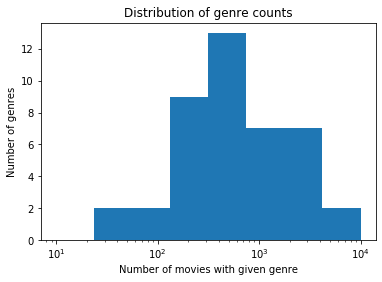

In [0]:
labelCounts = y_train.sum(axis=0)
n, bins, patches = plt.hist(labelCounts, bins=np.logspace(1, 4, 9))
plt.semilogx()
plt.title("Distribution of genre counts")
plt.xlabel("Number of movies with given genre")
plt.ylabel("Number of genres")

We see there are a handful of genres that appear in the training set less than a hundred times and some that appear many thousands of times with most appearing several hundred times.

## 2. Feature analysis and wrangling

In [0]:
genreDF = pd.DataFrame(y_train, columns = binarizer.classes_)
genreDF.Comedy.sum()/genreDF.Comedy.count()

0.3571320450073162

In [0]:
genreDF = pd.DataFrame(y_train, columns = binarizer.classes_)
genreDF.Action.sum()/genreDF.Action.count()

0.148594782784197

In [0]:
genreDF = pd.DataFrame(y_train, columns = binarizer.classes_)
genreDF.Adult.sum()/genreDF.Adult.count()

0.013017811191281094

So now let's wrangle the text. 

First, a review of the text shows that some of the data contains tags such as "{{plot}}" and "{{No plot}}" For Example

In [0]:
#Example 1
X_train.loc[23851782]

'{{plot}} The film opens with a Great Western express speeding out of Box Tunnel on route to Cornwall. The train\'s passengers include Herbert and Edna, a young couple travelling to Truro to be married, Miss Bourne, a West London spinster visiting evacuated relatives, Tommy Gander, an overenthusiastic Vaudeville-style comedian and entertainer headed for the Pier Pavilion at Newquay to put on a show, Dr Sterling, a locum for a doctor in Redruth, Richard G Winthrop and his cousin Jackie, also heading for Truro, and Teddy Deakin. Just as they are passing Teignmouth, the communication cord is pulled and the train stops - only for the guard and passengers to find that Gander has lost his hat and is running back to retrieve it. Ignorant of the delay this has caused, he returns to the train and comes across Jackie Winthrop in her compartment. Gander tries to make conversation with her, but Teddy has his eye on Jackie and is quick to try and send him packing - at one point he insinuates that G

In [0]:
#Example 2
X_train.loc[34980460]

'{{No plot}} This film follows 12 years in the lives of 3 Irish traveller familys  and their bitter feuds and fights. The film explores the reasons why they hold these fights and explores the in-depth secret lives of the familys, which is barely known to outsiders of the travelling community. A gripping tale of passion and respect and blood bonds that will never end.'

In fact these tags are contained in almost 8% of the training set. 

In [0]:
#for {{Plot}}
X_train.str.contains("{{\w*}}", case=False).mean()

0.04414955345880216

In [0]:
#for  {{No Plot}}
X_train.str.contains("{{\w* \w*}}", case=False).mean()

0.043190877440839597

Now we create a data wrangling pripeline

In [0]:
def deleteSynopsisTags_1(X):
  return X.str.replace("\s*{{\w*}}\s*", "", case=False)
    
def deleteSynopsisTags_2(X):
  return X.str.replace("\s*{{\w* \w*}}\s*", "", case=False)

deleteSynopsisTagsTransformer_1 = FunctionTransformer(deleteSynopsisTags_1, validate=False)
deleteSynopsisTagsTransformer_2 = FunctionTransformer(deleteSynopsisTags_2, validate=False)

X_wrangle_1 = deleteSynopsisTagsTransformer_1.fit_transform(X_train)
X_wrangle_2 = deleteSynopsisTagsTransformer_2.fit_transform(X_wrangle_1)

X_test_wrangle_1 = deleteSynopsisTagsTransformer_1.transform(X_test)
X_test_wrangle_2 = deleteSynopsisTagsTransformer_2.transform(X_test_wrangle_1)

And we see that these tags are now gone.

In [0]:
X_wrangle_2.loc[23851782]

'The film opens with a Great Western express speeding out of Box Tunnel on route to Cornwall. The train\'s passengers include Herbert and Edna, a young couple travelling to Truro to be married, Miss Bourne, a West London spinster visiting evacuated relatives, Tommy Gander, an overenthusiastic Vaudeville-style comedian and entertainer headed for the Pier Pavilion at Newquay to put on a show, Dr Sterling, a locum for a doctor in Redruth, Richard G Winthrop and his cousin Jackie, also heading for Truro, and Teddy Deakin. Just as they are passing Teignmouth, the communication cord is pulled and the train stops - only for the guard and passengers to find that Gander has lost his hat and is running back to retrieve it. Ignorant of the delay this has caused, he returns to the train and comes across Jackie Winthrop in her compartment. Gander tries to make conversation with her, but Teddy has his eye on Jackie and is quick to try and send him packing - at one point he insinuates that Gander is 

In [0]:
X_wrangle_2.loc[34980460]

'This film follows 12 years in the lives of 3 Irish traveller familys  and their bitter feuds and fights. The film explores the reasons why they hold these fights and explores the in-depth secret lives of the familys, which is barely known to outsiders of the travelling community. A gripping tale of passion and respect and blood bonds that will never end.'

So now I want to start making fits to the Comedy genre data, identifying the most important features and so finding possible sources of error. 

First though I need to choose an appropraite score to measure the fit quality. I will choose the micro f1 score which balanaces precision (reducing false negatives) and accuracy (reducing false positives). The is implemented here for a single label (Later I will extend this to multilabel).

In [0]:
def customF1(hat, actual, **kwargs):
    accuracy = ((actual*hat).sum())/actual.sum()
    precision = ((actual*hat).sum())/hat.sum()
    if accuracy==0 or precision==0:
        f1= 0
    else:
        f1= 2.* pow(pow(accuracy, -1) + pow(precision, -1), -1)
    return f1
customF1Scorer = make_scorer(customF1, greater_is_better=True)

So let's identify the most important features and the quality of the fit. The folloiwng code vectorizes the synopsis, and prints out the 200 most important words for determing whether a movie is a comedy using a $\chi^2$ imformation metric. Next we perform a fit over the most important features and print the resulting cross validation score and training score. By printing both we will identify possible overfitting.

In [0]:
def mostImportantFeatures(X, y):
    count = CountVectorizer(lowercase=False, strip_accents='unicode', min_df = 3, stop_words='english')
    #print the most important features
    selector = SelectKBest(chi2, 200)
    X_Vec = count.fit_transform(X, y)
    X_select = selector.fit_transform(X_Vec, y)
    print (np.unique([name for name, val in zip(count.get_feature_names(), selector.get_support()) if val==True]))
    #get a fit score based on the most important featrures
    MultinomialPipe = Pipeline([
                                ("count", count),
                                ("selector", SelectPercentile(chi2)),
                                ("model", MultinomialNB(alpha = 1e-9, fit_prior=False))
                               ])
    rs = RandomizedSearchCV(MultinomialPipe, param_distributions={"selector__percentile":sp_randint(1, 50)}, 
                            n_iter=3,
                            scoring=customF1Scorer, verbose=0, 
                            refit=True, 
                            cv=10
                           )
    rs.fit(X, y)
    hYat = rs.predict(X)
    return rs.best_score_ , rs.best_params_, customF1(y, hYat)

In [0]:
best_score, best_params, custom_F1 = mostImportantFeatures(X_wrangle_2, genreDF.Comedy)

['Adam' 'Alfalfa' 'Alfie' 'Andy' 'Anne' 'Archie' 'Austin' 'Bean' 'Beverly'
 'Big' 'Bond' 'Brad' 'British' 'Buddy' 'Bugs' 'Butch' 'Casey' 'Catherine'
 'Charlie' 'Cheech' 'Chester' 'Chip' 'Christine' 'Chuck' 'Chucky' 'Cindy'
 'Clouseau' 'Crewe' 'Curly' 'Daffy' 'Darla' 'Dave' 'David' 'Deuce'
 'Dexter' 'Dr' 'Duck' 'Dwayne' 'Ed' 'Elmer' 'Elwood' 'Ernest' 'Ernie'
 'Evil' 'Fiona' 'Fitz' 'Fred' 'Garfield' 'George' 'German' 'Germans'
 'Gromit' 'Hardy' 'Harold' 'Herbie' 'Hollywood' 'Jackie' 'Japanese'
 'Jerry' 'Jimmy' 'John' 'Joseph' 'Josh' 'Judy' 'Kevin' 'Larry' 'Loretta'
 'Louie' 'Madea' 'Mame' 'Massie' 'Max' 'Miss' 'Mitch' 'Moe' 'Monty' 'Mr'
 'Odie' 'Olive' 'Ollie' 'Pee' 'Pink' 'Porky' 'Ralph' 'Roger' 'Rowley'
 'Sach' 'Sam' 'Scam' 'Sharpe' 'Shemp' 'Shrek' 'Slip' 'Spanky' 'Spike'
 'Stan' 'Stooges' 'TV' 'Tarzan' 'Tiffany' 'Tom' 'Wally' 'Wang' 'War'
 'Woody' 'accidentally' 'alive' 'antics' 'attack' 'attacked' 'attacks'
 'ball' 'band' 'battle' 'best' 'bet' 'blood' 'body' 'boyfriend' 'boys'
 'cart

In [0]:
print("Randomized Search best score: {}".format(best_score))
print("grid search best param : {}".format(best_params))
print("score on training data : {}".format(custom_F1))

Randomized Search best score: 0.6519936616330153
grid search best param : {'selector__percentile': 15}
score on training data : 0.7566704966168774


We see that many of the most important features are names. While we might imagine that a few names could hold some predictive power, the use of names seems likely to contribute to the overfitting we observe. Lets remove them.

In [0]:
def noCaps(X):
    return X.str.replace(r'([A-Z])\w+', "", case=True)

noCapsTransform = FunctionTransformer(noCaps, validate=False)

X_wrangle_3 = noCapsTransform.fit_transform(X_wrangle_2)
X_test_wrangle_3 = noCapsTransform.transform(X_test_wrangle_2)

best_score, best_params, custom_F1 = mostImportantFeatures(X_wrangle_3, genreDF.Comedy)

['accidentally' 'actor' 'advertising' 'advice' 'aircraft' 'alive' 'antics'
 'army' 'attack' 'attacked' 'attacks' 'audience' 'bachelor' 'ball' 'band'
 'bar' 'battle' 'best' 'bet' 'big' 'blood' 'body' 'bong' 'bowling' 'boy'
 'boyfriend' 'boys' 'brother' 'bumbling' 'business' 'butler' 'buy'
 'cartoon' 'cat' 'ceremony' 'cheerleader' 'chef' 'child' 'college'
 'comedy' 'comic' 'commander' 'company' 'competition' 'contest' 'cow'
 'creature' 'credits' 'crew' 'crime' 'crush' 'dad' 'dance' 'date' 'dating'
 'daughter' 'dead' 'death' 'decide' 'decides' 'demon' 'died' 'dies'
 'dinner' 'doesn' 'dog' 'drug' 'duo' 'dying' 'eccentric' 'end' 'ends'
 'escape' 'evidence' 'executed' 'feelings' 'fish' 'forces' 'friends' 'fun'
 'game' 'garbage' 'gay' 'gets' 'getting' 'girlfriend' 'girls' 'golf'
 'government' 'group' 'gun' 'guys' 'happy' 'helicopter' 'hockey' 'hotel'
 'human' 'idea' 'inept' 'infected' 'information' 'injured' 'investigate'
 'investigation' 'job' 'kids' 'kill' 'killed' 'killer' 'killing' 'kills

In [0]:
print("Randomized Search best score: {}".format(best_score))
print("grid search best param : {}".format(best_params))
print("score on training data : {}".format(custom_F1))

Randomized Search best score: 0.6618761633081326
grid search best param : {'selector__percentile': 27}
score on training data : 0.7428427609639463


We have reduced overfitting by quite a bit, although it would have been better if this gain had come from increased predictive power rather than reducing the training score. 

Next, we see a number of very similar words appearing, perhaps suggesting that we should use stemming to improve the fit

In [0]:
from nltk.stem.porter import *
from nltk import tokenize
stemmer = PorterStemmer()
tokenizer = tokenize.WordPunctTokenizer()
def stemCustom(X):
    splitStemJoin = lambda string: ' '.join([stemmer.stem(word) for word in tokenizer.tokenize(string)])
    return X.apply(splitStemJoin)

stemTransform = FunctionTransformer(stemCustom, validate=False)

X_wrangle_4 = stemTransform.fit_transform(X_wrangle_3)
X_test_wrangle_4 = stemTransform.transform(X_test_wrangle_3)

best_score, best_params, custom_F1 = mostImportantFeatures(X_wrangle_4, genreDF.Comedy)

['accident' 'actor' 'advertis' 'advic' 'aircraft' 'aliv' 'ambush'
 'announc' 'annoy' 'antic' 'arm' 'armi' 'attack' 'audienc' 'bachelor'
 'ball' 'band' 'battl' 'best' 'bet' 'blood' 'boat' 'bodi' 'bong' 'bowl'
 'boyfriend' 'brutal' 'bumbl' 'burn' 'busi' 'butler' 'buy' 'cartoon' 'cat'
 'chase' 'cheerlead' 'chef' 'child' 'civilian' 'clumsi' 'colleg' 'comedi'
 'comic' 'command' 'compani' 'competit' 'contest' 'creatur' 'credit'
 'crew' 'crime' 'dad' 'danc' 'dark' 'date' 'daughter' 'dead' 'death'
 'decid' 'demon' 'destroy' 'die' 'dinner' 'disguis' 'dog' 'dragon' 'dress'
 'drug' 'eccentr' 'embarrass' 'end' 'escap' 'evid' 'fighter' 'flashback'
 'forc' 'friend' 'fun' 'game' 'gay' 'girlfriend' 'golf' 'govern' 'group'
 'guest' 'gun' 'guy' 'helicopt' 'hockey' 'hotel' 'human' 'hunt' 'idea'
 'impress' 'inept' 'infect' 'inform' 'investig' 'invit' 'job' 'joke' 'kid'
 'kill' 'killer' 'kiss' 'knife' 'ladi' 'love' 'make' 'man' 'marijuana'
 'marri' 'men' 'militari' 'misadventur' 'missil' 'mission' 'mistak'

In [0]:
print("Randomized Search best score: {}".format(best_score))
print("grid search best param : {}".format(best_params))
print("score on training data : {}".format(custom_F1))

Randomized Search best score: 0.6614634830647452
grid search best param : {'selector__percentile': 36}
score on training data : 0.7198648141194142


Again we appear to have reduced overfitting but without improving the actual fit. Let's try looking at a different genre.

In [0]:
best_score, best_params, custom_F1 = mostImportantFeatures(X_wrangle_4, genreDF.Documentary)

['02' '1990' '2000' '2001' '2002' '2003' '2004' '2006' '2007' '2008'
 '2009' '2010' '2011' '3D' 'accessd' 'activist' 'agre' 'album' 'alleg'
 'archiv' 'arriv' 'art' 'ask' 'attack' 'attempt' 'away' 'bailout'
 'bassist' 'becom' 'befor' 'began' 'believ' 'billion' 'bodi' 'booksel'
 'boy' 'break' 'camera' 'car' 'caus' 'censorship' 'chase' 'chronicl'
 'cite' 'clip' 'coalit' 'cochlear' 'com' 'come' 'commentari' 'concert'
 'contemporari' 'context' 'contribut' 'controversi' 'convinc' 'coral'
 'corpu' 'creativ' 'cub' 'cultur' 'daughter' 'dead' 'decid' 'deficit'
 'democraci' 'democrat' 'depict' 'deregul' 'describ' 'die' 'director'
 'discov' 'discuss' 'document' 'documentari' 'doe' 'dolphin' 'econom'
 'escap' 'ethnic' 'eugen' 'evolut' 'examin' 'excerpt' 'explor' 'fall'
 'father' 'featur' 'fight' 'film' 'filmmak' 'flamingo' 'focu' 'focus'
 'footag' 'friend' 'genocid' 'girl' 'global' 'goe' 'govern' 'guitarist'
 'gun' 'ha' 'head' 'healthcar' 'help' 'hi' 'highlight' 'histor' 'histori'
 'home' 'hominid'

In [0]:
print("Randomized Search best score: {}".format(best_score))
print("grid search best param : {}".format(best_params))
print("score on training data : {}".format(custom_F1))

Randomized Search best score: 0.385500836937402
grid search best param : {'selector__percentile': 22}
score on training data : 0.4979291302346986


Here the fit is very much worse than for comedy. Also notice notice the presence of numbers which could be a source of error so let's try removing them.

In [0]:
def noDigits(X):
    return X.str.replace(r'\d+\,?\.?\d?', "")

noDigitsTransform = FunctionTransformer(noDigits, validate=False)

X_wrangle_5 = noDigitsTransform.fit_transform(X_wrangle_4)
X_test_wrangle_5 = noDigitsTransform.transform(X_test_wrangle_4)

In [0]:
best_score, best_params, custom_F1 = mostImportantFeatures(X_wrangle_5, genreDF.Documentary)

['accessd' 'activist' 'agre' 'album' 'alleg' 'anoth' 'apart' 'archiv'
 'arriv' 'art' 'ask' 'attack' 'attempt' 'away' 'bailout' 'bassist' 'becom'
 'befor' 'began' 'believ' 'billion' 'bodi' 'booksel' 'boy' 'break'
 'camera' 'car' 'caus' 'censorship' 'chase' 'chronicl' 'cite' 'clip'
 'coalit' 'cochlear' 'com' 'come' 'commentari' 'concert' 'contemporari'
 'context' 'contribut' 'controversi' 'convinc' 'coral' 'corpu' 'creativ'
 'cub' 'cultur' 'daughter' 'dead' 'decid' 'deficit' 'democraci' 'democrat'
 'depict' 'deregul' 'describ' 'die' 'director' 'discov' 'discuss'
 'document' 'documentari' 'doe' 'dolphin' 'drive' 'earli' 'econom' 'escap'
 'ethnic' 'eugen' 'evolut' 'examin' 'excerpt' 'explor' 'fall' 'father'
 'featur' 'fight' 'film' 'filmmak' 'flamingo' 'focu' 'focus' 'footag'
 'friend' 'genocid' 'girl' 'global' 'goe' 'govern' 'guitarist' 'gun' 'ha'
 'head' 'healthcar' 'help' 'hi' 'hide' 'highlight' 'histor' 'histori'
 'home' 'hominid' 'hous' 'html' 'http' 'humpback' 'husband' 'hydrogen'
 '

In [0]:
print("Randomized Search best score: {}".format(best_score))
print("grid search best param : {}".format(best_params))
print("score on training data : {}".format(custom_F1))

Randomized Search best score: 0.38036962473042824
grid search best param : {'selector__percentile': 25}
score on training data : 0.5250364608653378


The fit is the same and, there is a greater amount of overfitting, it makes sense to remove digits from the data set. Finally we need to transform the vectorised synopsis data into an numpy array and then bring all the steps together into a preprocessing pipeline.

In [0]:
def transformToNp(X):
    return X.values.flatten()

transformToNpTransform = FunctionTransformer(transformToNp, validate=False)

X_wrangled = transformToNpTransform.fit_transform(X_wrangle_5)
X_test_wrangled = transformToNpTransform.transform(X_test_wrangle_5)

# 4. Multilabel Classification Algorithms

In [0]:
def averageF1Micro(y, yPredicted, **kwargs):
    #if a row in y has no labels assume that its genres were not in the training set and give 0
    return np.mean([f1_score(sub_y, sub_ypredicted, labels=[1], average='micro') 
                    if sum(sub_ypredicted)!=0 else 0 
                    for sub_y, sub_ypredicted in zip(y,yPredicted) if sum(sub_y)!=0] )

averageF1MicroScorer = make_scorer(averageF1Micro, greater_is_better=True)

In [0]:
class MinSampleClassifier(BaseEstimator, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), limit=10, decisionFunction=False):
        self.clf = clf
        self.limit = limit
        self.decisionFunction = decisionFunction
        
    def fit(self, X, y):
        if sum(y)<self.limit:
            self.dataTooSmall_ = True
        else:
            self.dataTooSmall_ = False
            self.clf.fit(X,y)
        return self
    
    def predict(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        else:
            return self.clf.predict(X)
        
    def decision_function(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        elif self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            return self.clf.predict_proba(X)[:,1]

Models fall in to two categories. Those, like naive bayes, which can predict the probability that a given data point has a specific label and those that use a decision function.

I will create a machine learning algorithm and use it to transform the data into a measure of fit, either a probability or a decision function score.

In [0]:
class PredictionTransformer(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), decisionFunction=True):
        """Replaces all features with `clf.predict_proba(X)`"""
        self.clf = clf
        self.decisionFunction=decisionFunction
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        if self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            X_array = np.asarray(X)
            probs = self.clf.predict_proba(X)
            return [val[:,1] if val.shape[1]==2 else [0]*val.shape[0] for val in probs ]

Next I will create a class that allows the value of the threshold to be raised or lowered. However this may lead to situations where no labels are predicted. In this case I want to predict the n labels with the highest scores or probabilities, even if those are quite low. 

In [0]:
def thresholdCalc(threshold, minCount, x):
        #predict values above a threshold or else the most confident minCount
    initialThreshold = x>=threshold
    if initialThreshold.sum() >=minCount:
        return initialThreshold
    else:
        indexes = np.argpartition(x, -minCount)[-minCount:]
        lowerThreshold = x[indexes].min()
        if lowerThreshold>0 and minCount<len(x):
            return x>=lowerThreshold
        else:
            return x>0
        
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, minCount = 2, transpose=True):
        """Classify samples based on whether they are above of below `threshold`"""
        self.threshold = threshold
        self.minCount = minCount
        self.transpose=transpose

    def fit(self, X, y):
        return self

    def predict(self, X):
        X_array = np.asarray(X)
        if self.transpose:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array]).T
        else:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array])
        return returnVal
    
    #This method is required by the OneVsRestClassifier 
    def predict_proba(self, X):
        return X

## 5. Defining and tuning models

All of the models we are going to try will have a number of parameters that must be tuned using cross validation. Rather than repeat this boiler plate code for each model I will create a simple function that searches the available parameter space for the best values printing out the best results. 

In [0]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def crossValidateRandom(X, Y, model, params=None, n_iter=100):
    rsCV = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter,
                            scoring=averageF1MicroScorer, verbose=1,cv=10, n_jobs = -1
                           )
    fittedModel = rsCV.fit(X, Y)
    report(rsCV.cv_results_)
    return rsCV.best_params_, rsCV

For each model I will use the same function to vectorize the text data, called CountVectorizer. Note that an alternative vectorizer exists, tfIdfVectorizer but with it I have found that the results are not as good.

In [0]:
count = CountVectorizer(lowercase=False, strip_accents='unicode', stop_words='english')

# Naive Bayes

This model is a staple of any attempt at text analysis. For this model I will create a naive bayes model for each genre and then use the threshold predictor to find the most likely labels.

In [0]:
class logUniform():
    def __init__(self, low = -9, high = 0):
        self.rng = sp_uniform(low, high-low) #This distribution is constant between `loc` and ``loc + scale``.
        
    def rvs(self, **kwargs):
        return 10**(self.rng.rvs(**kwargs))

The model first vectorizes the data. Then for each label it selects the most important features and then applies Naive Bayes. Thresholding is then used to predict the best labels.

In [0]:
import warnings
warnings.filterwarnings("ignore")

selectThenNBPipe = Pipeline([("selector", SelectPercentile(chi2)),
                             ("prediction",MultinomialNB())])

multipleNB = OneVsRestClassifier(MinSampleClassifier(selectThenNBPipe, decisionFunction=False))

naiveBayes = Pipeline([("count",count), 
                       ("model", PredictionTransformer(clf=multipleNB)),
                       ("threshold", ThresholdClassifier(transpose=False))])

NBparams = {"count__max_df":sp_uniform(0.8, 1.0),
            "count__min_df":sp_randint(1,4),
            "model__clf__estimator__clf__prediction__alpha":logUniform(low=-12, high=0),
            "model__clf__estimator__clf__prediction__fit_prior":[True, False],
            "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
            "threshold__threshold":sp_uniform(0, 0.5),
            "threshold__minCount":sp_randint(2, 6)
           }

NBModelBestParams, NaveModel = crossValidateRandom(X_wrangled, y_train, naiveBayes, params=NBparams, n_iter=25)
naiveBayes.set_params(**NBModelBestParams)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 33.8min finished


Model with rank: 1
Mean validation score: 0.520 (std: 0.003)
Parameters: {'count__max_df': 1.3613949363320534, 'count__min_df': 2, 'model__clf__estimator__clf__prediction__alpha': 0.0004730984482828063, 'model__clf__estimator__clf__prediction__fit_prior': True, 'model__clf__estimator__clf__selector__percentile': 87, 'threshold__minCount': 3, 'threshold__threshold': 0.1597052108949124}

Model with rank: 2
Mean validation score: 0.518 (std: 0.003)
Parameters: {'count__max_df': 1.2542236009275753, 'count__min_df': 3, 'model__clf__estimator__clf__prediction__alpha': 2.7412550728534626e-05, 'model__clf__estimator__clf__prediction__fit_prior': True, 'model__clf__estimator__clf__selector__percentile': 52, 'threshold__minCount': 2, 'threshold__threshold': 0.25416874374535425}

Model with rank: 3
Mean validation score: 0.495 (std: 0.003)
Parameters: {'count__max_df': 1.1320039384299772, 'count__min_df': 2, 'model__clf__estimator__clf__prediction__alpha': 1.6400708433775654e-05, 'model__clf__est

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False,
                                 max_df=1.3613949363320534, max_features=None,
                                 min_df=2, ngram_range=(1, 1),
                                 preprocessor=None, stop_words='english',
                                 strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 to...
                                                                                                                  SelectPercentile(percentile=87,
                                                                                                                                   score_func=<function chi2 a

In [0]:
NaveBayesModel = NaveModel.best_estimator_

Results for Naive Bayes

In [0]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [0]:
y_pred = NaveModel.predict(X_test_wrangled)
print("Average Micro F1 Score: {}".format(averageF1Micro(y_test, y_pred)))
print("Precision Score: {}".format(precision_score(y_test, y_pred, average='micro')))
print("Recall Score: {}".format(recall_score(y_test, y_pred, average='micro')))

Average Micro F1 Score: 0.5235301471124361
Precision Score: 0.4299866641265003
Recall Score: 0.6804854149393231


We see a best cross validation score of 0.520 for the naive bayes model. This is a good result but we should still experiment with different models. 

# Random Forest

This model is easier to apply than naive bayes since it natively copes with multiple labels. This model was very slow to fit in the presence of so 1000's of features. I found the best results came not when I found the best subset of features but instead by performing Singular Value Decomposition on the features, reducing the number of dimensions down to 100. 

In [0]:
import warnings
warnings.filterwarnings("ignore")
randomForest = Pipeline([("count", count),
                         ("TruncatedSVD", TruncatedSVD(n_components=100)),
                         ("model", PredictionTransformer(clf=RandomForestClassifier(), decisionFunction=False)), 
                         ("prob", ThresholdClassifier())
                        ])

multiRFParams={
               "model__clf__n_estimators":[15, 20, 25], 
               "model__clf__max_depth":[10, 20, 25], 
               "model__clf__min_samples_split":[3,5,7],
               "prob__threshold":[0.4, 0.5],
               "prob__minCount":[2,3,4]
              }

randomRFParams={
                "count__max_df":sp_uniform(0.8, 1.0),
                "count__min_df":sp_randint(1,4),
                "model__clf__n_estimators":sp_randint(10, 30),
                "model__clf__max_depth":sp_randint(5, 50),
                "model__clf__min_samples_split":sp_randint(2, 8),
                "prob__threshold":sp_uniform(0, 0.5),
                "prob__minCount":sp_randint(2, 6)
               }

randomForestBestParams, Random_Model = crossValidateRandom(X_wrangled, y_train, randomForest, 
                                             params=randomRFParams, n_iter=15)
randomForest.set_params(**randomForestBestParams)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 57.4min finished


Model with rank: 1
Mean validation score: 0.464 (std: 0.004)
Parameters: {'count__max_df': 0.9441002189941308, 'count__min_df': 3, 'model__clf__max_depth': 20, 'model__clf__min_samples_split': 7, 'model__clf__n_estimators': 28, 'prob__minCount': 3, 'prob__threshold': 0.1883523963953463}

Model with rank: 2
Mean validation score: 0.461 (std: 0.004)
Parameters: {'count__max_df': 1.3792066514765775, 'count__min_df': 2, 'model__clf__max_depth': 12, 'model__clf__min_samples_split': 4, 'model__clf__n_estimators': 22, 'prob__minCount': 2, 'prob__threshold': 0.23680001101598058}

Model with rank: 3
Mean validation score: 0.455 (std: 0.005)
Parameters: {'count__max_df': 1.689132894788194, 'count__min_df': 1, 'model__clf__max_depth': 12, 'model__clf__min_samples_split': 2, 'model__clf__n_estimators': 15, 'prob__minCount': 5, 'prob__threshold': 0.20714282610509355}



Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=False,
                                 max_df=0.9441002189941308, max_features=None,
                                 min_df=3, ngram_range=(1, 1),
                                 preprocessor=None, stop_words='english',
                                 strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 to...
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
                                    

In [0]:
Random_Forest_Model = Random_Model.best_estimator_

Results for Random Forest

In [0]:
X_test_wrangled = preprocessing.transform(X_test)
y_pred = Random_Forest_Model.predict(X_test_wrangled)
print("Average Micro F1 Score: {}".format(averageF1Micro(y_test, y_pred)))
print("Precision Score: {}".format(precision_score(y_test, y_pred, average='micro')))
print("Recall Score: {}".format(recall_score(y_test, y_pred, average='micro')))

Average Micro F1 Score: 0.46591851711112275
Precision Score: 0.395722993904267
Recall Score: 0.5969699253787594


Naive Bayes is the better model than Random Forest due to high F1 Score. F1 Score is beneficial in multilabel classification, when there is uneven class distribution